In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from drail.learn.local_learner import LocalLearner
from mf_features import MoralFoundationFE
import json
import torch

torch.cuda.set_device(0)

In [2]:
learner = LocalLearner(infer_algorithm='AD3')
learner.set_savedir("local_shamik")

In [3]:
learner.build_parser()

In [4]:
learner.define_entity("Event")
learner.define_entity("Tweet")
learner.define_entity("Entity")
learner.define_entity("Role")
learner.define_entity("MoralFoundation")
learner.define_entity("Topic")
learner.define_entity("Ideology")
#learner.define_entity("EntityGroup")
#learner.define_entity("Polarity")

In [5]:
learner.define_label("RoleLabel", n_classes=16, data_file="examples/mf_role/data/role.txt")
learner.define_label("MfLabel", n_classes=5, data_file="examples/mf_role/data/mf.txt")

In [6]:
learner.define_predicate("InInstance", entities=["Tweet", "Event"], data_file="examples/mf_role/data/in_instance_topic_ideo.txt")
learner.define_predicate("HasEntity", entities=["Tweet", "Entity"], data_file="examples/mf_role/data/has_entity.txt")
learner.define_predicate("HasRole", entities=["Tweet", "Entity", "Role"], data_file="examples/mf_role/data/has_role.txt")
learner.define_predicate("HasMf", entities=["Tweet", "MoralFoundation"], data_file="examples/mf_role/data/has_mf.txt")
learner.define_predicate("RoleHasMf", entities=["Role", "MoralFoundation"], data_file="examples/mf_role/data/role_has_mf.txt")
learner.define_predicate("HasTopic", entities=["Tweet", "Topic"], data_file="examples/mf_role/data/has_topic.txt")
learner.define_predicate("HasIdeology", entities=["Tweet", "Ideology"], data_file="examples/mf_role/data/has_ideology.txt")
#learner.define_predicate("HasEntityGroup", entites=["Entity", "EntityGroup"], data_file="examples/mf_role/data/has_entity_group.txt")
#learner.define_predicate("RoleHasPolarity", entites=["Role", "Polarity"], data_file="examples/mf_role/data/role_has_polarity.txt")

In [7]:
learner.fe = MoralFoundationFE(data_f="examples/mf_role/data/drail_data_bert.pickle", features_f="examples/mf_role/data/one_hot_features.pickle")

In [8]:
learner.define_rule(
    "InInstance(T, Z) & HasEntity(T, E) => HasRole(T, E, R^RoleLabel?)",
    lmd=1.0,
    features=["tweet_bert", "entity_bert_second"]
)

learner.define_rule(
    "InInstance(T, Z) => HasMf(T, M^MfLabel?)",
    lmd=1.0,
    features=["tweet_bert"]
)

learner.define_rule(
    "InInstance(T, Z) & HasIdeology(T, I) & HasTopic(T, S) => HasMf(T, M^MfLabel?)",
    lmd=1.0,
    features=["tweet_bert", "ideology1hot", "topic1hot"]
)

learner.define_rule(
    "InInstance(T, Z) & HasEntity(T, E) & HasIdeology(T, I) & HasTopic(T, S) => HasRole(T, E, R^RoleLabel?)",
    lmd=1.0,
    features=["tweet_bert", "entity_bert_second", "ideology1hot", "topic1hot"]
)

learner.define_hardconstr(
    "InInstance(T, Z) & HasEntity(T, E) & RoleHasMf(R, M) & HasRole(T, E, R)^? => HasMf(T, M)^?"
)

#learner.define_hardconstr(
#    'InInstance(T, Z) & InInstance(S, Z) & & (T!=S) & HasEntity(T, E) & HasEntity(S, F) & HasEntityGroup(E, G) & HasEntityGroup(F, G) & HasTopic(T, H) & HasTopic(S, H) & HasIdeology(T, I) & HasIdeology(S, I) & RoleHasPolarity(U, "positive") & RoleHasPolarity(V, "negative") & HasRole(T, E, U)^? => ~HasRole(S, F, V)^?
#)

In [9]:
learner.define_scope(pred_name="InInstance", entity_name="Event")

In [10]:
db = learner.create_dataset(".")

I0815 21:49:22.725377 140305624835904 learner.py:150] self.par.files={'RoleLabel': 'examples/mf_role/data/role.txt', 'MfLabel': 'examples/mf_role/data/mf.txt', 'InInstance': 'examples/mf_role/data/in_instance_topic_ideo.txt', 'HasEntity': 'examples/mf_role/data/has_entity.txt', 'HasRole': 'examples/mf_role/data/has_role.txt', 'HasMf': 'examples/mf_role/data/has_mf.txt', 'RoleHasMf': 'examples/mf_role/data/role_has_mf.txt', 'HasTopic': 'examples/mf_role/data/has_topic.txt', 'HasIdeology': 'examples/mf_role/data/has_ideology.txt'}
I0815 21:49:22.727601 140305624835904 database_new.py:55] CREATE TABLE InInstance (TweetId_1 TEXT, EventId_2 TEXT)
I0815 21:49:22.746775 140305624835904 database_new.py:55] CREATE TABLE HasEntity (TweetId_1 TEXT, EntityId_2 TEXT)
I0815 21:49:22.781391 140305624835904 database_new.py:55] CREATE TABLE HasRole (TweetId_1 TEXT, EntityId_2 TEXT, RoleId_3 TEXT)
I0815 21:49:22.823030 140305624835904 database_new.py:55] CREATE TABLE HasMf (TweetId_1 TEXT, MoralFoundati

In [11]:
import random

random.seed(4321)

tweets = [x.split('\t')[0] for x in open("examples/mf_role/data/in_instance_topic_ideo.txt").readlines()]
random.shuffle(tweets)

# Take 80% for train, 20% for test
n_train = int(len(tweets)*0.8)
train_tweets = tweets[:n_train]
test_tweets= tweets[n_train:]

# Now take 10% of the training set for development
n_dev = int(n_train*0.1)
dev_tweets = train_tweets[:n_dev]
train_tweets = train_tweets[n_dev:]

In [12]:
db.add_filters(filters=[
    ("InInstance", "isTest", "TweetId_1", test_tweets)]
)

In [13]:
learner.build_feature_extractors(db, filters=[("InInstance", "isDummy", 1)])

In [14]:
config = json.load(open("mf_config.json"))
learner.build_models(db, config, isdic=True, netmodules_path=".")
learner.init_models()

I0815 21:49:23.123278 140305624835904 learner.py:387] InInstance(T,Z) & HasEntity(T,E) => HasRole(T,E,R^RoleLabel-Multiclass-16)
I0815 21:49:23.123788 140305624835904 learner.py:419] Building nnet for predicate HasRole
I0815 21:49:23.124311 140305624835904 learner.py:280] ./mf_networks.py
I0815 21:49:27.262955 140305624835904 learner.py:387] InInstance(T,Z) => HasMf(T,M^MfLabel-Multiclass-5)
I0815 21:49:27.263532 140305624835904 learner.py:419] Building nnet for predicate HasMf
I0815 21:49:27.263966 140305624835904 learner.py:280] ./mf_networks.py
I0815 21:49:29.492168 140305624835904 learner.py:387] InInstance(T,Z) & HasIdeology(T,I) & HasTopic(T,S) => HasMf(T,M^MfLabel-Multiclass-5)
I0815 21:49:29.493105 140305624835904 learner.py:419] Building nnet for predicate HasMf
I0815 21:49:29.493466 140305624835904 learner.py:280] ./mf_networks.py
I0815 21:49:31.701165 140305624835904 learner.py:387] InInstance(T,Z) & HasEntity(T,E) & HasIdeology(T,I) & HasTopic(T,S) => HasRole(T,E,R^RoleLabe

In [15]:
learner.extract_instances(db, extract_test=True, test_filters=[("InInstance", "isTest", 1)])

In [16]:
res, heads = learner.predict(db, fold_filters=[("InInstance", "isTest", 1)], fold='test', get_predicates=True)

I0815 21:49:34.774534 140305624835904 local_learner.py:297] predicting...
100%|██████████| 12/12 [00:06<00:00,  1.89it/s]


In [17]:
#print(res.metrics)

from sklearn.metrics import *

for pred in ['HasMf', 'HasRole']:
    y_gold = res.metrics[pred]['gold_data']
    y_pred = res.metrics[pred]['pred_data']
    
    #print(y_gold)
    #print(y_pred)
    
    print(pred)
    print(classification_report(y_gold, y_pred, digits=4))

HasMf
              precision    recall  f1-score   support

   authority     0.8571    0.7407    0.7947        81
        care     0.7551    0.8810    0.8132       126
    fairness     0.6667    0.5333    0.5926        45
     loyalty     0.7250    0.7250    0.7250        40
    sanctity     1.0000    0.8000    0.8889         5

    accuracy                         0.7677       297
   macro avg     0.8008    0.7360    0.7629       297
weighted avg     0.7696    0.7677    0.7641       297

HasRole
              precision    recall  f1-score   support

authority-q2     0.4375    0.4828    0.4590        29
authority-q3     1.0000    0.4000    0.5714        15
authority-q4     0.6111    0.6875    0.6471        48
authority-q5     0.6944    0.6250    0.6579        40
     care-q1     0.7347    0.8000    0.7660        90
     care-q2     0.8191    0.8556    0.8370        90
     care-q3     0.6832    0.7931    0.7340        87
 fairness-q2     0.6071    0.4857    0.5397        35
 fairness-

In [19]:
evaluation.get_moral_foundations()

['authority', 'fairness', 'care', 'sanctity', 'loyalty']

In [20]:
evaluation.top_k_entities(ideology='right', topic='abort')

[(('obamacare', 'do-cheat'), 1),
 (('planned parenthood executive', 'cause-degradation'), 1),
 (('we', 'provide-care'), 1),
 (('rogers', 'just-auth'), 1),
 (('body parts', 'target-purity-degrad'), 1)]

In [21]:
evaluation.top_k_entities(ideology='left', topic='abort')

[(('women', 'target-fair-cheat'), 4),
 (('scotus', 'ensure-fair'), 4),
 (('stand with pp', 'target-loyal-betray'), 2),
 (('hobby lobby decision', 'fail-auth'), 1),
 (('clinics in texas', 'target-care-harm'), 1)]

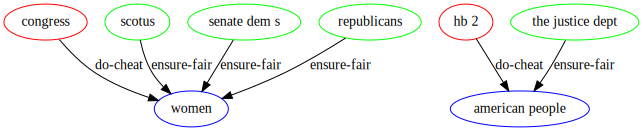

In [22]:
evaluation.entity_graph(topic='abort', ideology='left', mf='fairness')

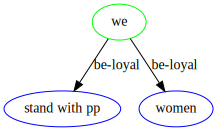

In [23]:
evaluation.entity_graph(topic='abort', ideology='left', mf='loyalty')

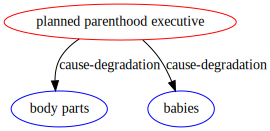

In [24]:
evaluation.entity_graph(topic='abort', ideology='right', mf='sanctity')

In [25]:
evaluation.top_k_entities(ideology='right', topic='aca')

[(('obamacare', 'cause-harm'), 8),
 (('americans', 'fail-auth-over'), 6),
 (('obamacare', 'fail-auth'), 4),
 (('small businesses', 'target-care-harm'), 3),
 (('obamacare', 'just-auth'), 3)]

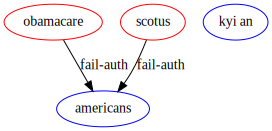

In [26]:
evaluation.entity_graph(topic='aca', ideology='right', mf='authority')

In [27]:
evaluation.get_roles()

['target-fair-cheat',
 'ensure-fair',
 'do-cheat',
 'just-auth',
 'just-auth-over',
 'fail-auth',
 'fail-auth-over',
 'target-purity-degrad',
 'preserve-purity',
 'cause-degradation',
 'target-care-harm',
 'cause-harm',
 'provide-care',
 'target-loyal-betray',
 'be-loyal',
 'do-betray']

In [28]:
evaluation.top_k_entities_per_role(ideology='left', topic='abort', role='target-care-harm')

[('clinics in texas', 1),
 ('war on women', 1),
 ('americans', 1),
 ('women', 1),
 ('women s health', 1)]

In [29]:
evaluation.top_k_entities_per_role(ideology='right', topic='abort', role='target-care-harm')

[]

In [30]:
evaluation.get_frequent_entities(topic='abort')

[('women', 7),
 ('scotus', 6),
 ('stand with pp', 3),
 ('planned parenthood', 3),
 ('hobby lobby decision', 2),
 ('senate dem s', 2),
 ('ppfa', 2),
 ('war on women', 2),
 ('we', 2),
 ('americans', 2)]

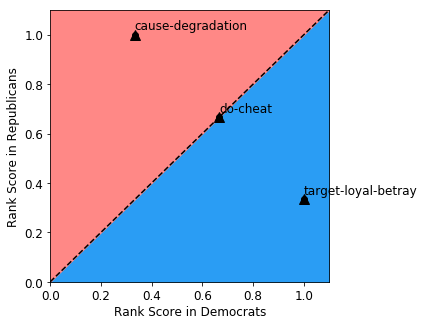

In [31]:
evaluation.role_polarity_graph(topic='abort', entity='planned parenthood')

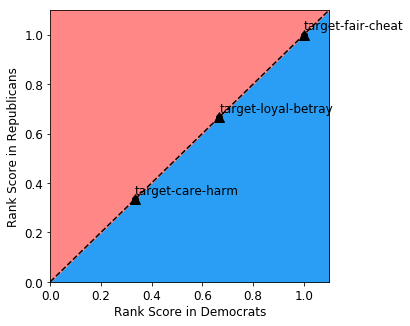

In [38]:
evaluation.role_polarity_graph(topic='abort', entity='women')

In [39]:
evaluation.role_polarity_graph(topic='abort', entity='scotus')

In [32]:
evaluation.mf_graph(topic='abort')

In [33]:
evaluation.mf_graph(topic='aca')

In [34]:
evaluation.mf_polarity_graph(topic='aca')

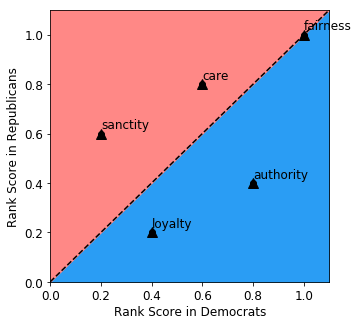

In [35]:
evaluation.mf_polarity_graph(topic='abort')

In [36]:
evaluation.get_frequent_entities(topic='isis', k=20)

[('we', 9),
 ('terrorist attack', 5),
 ('isis', 5),
 ('terrorists', 4),
 ('terrorism', 3),
 ('americans', 3),
 ('senate', 3),
 ('refugees', 3),
 ('potus', 2),
 ('troops', 2),
 ('rep hal rogers', 2),
 ('boko haram', 2),
 ('victims', 2),
 ('is il', 2),
 ('inhofe', 2),
 ('girls', 2),
 ('kurds', 1),
 ('brussels', 1),
 ('our nation', 1),
 ('congress', 1)]

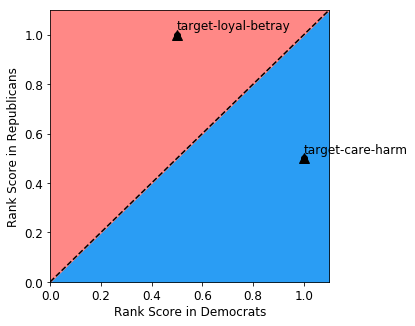

In [37]:
evaluation.role_polarity_graph(topic='isis', entity='refugees')